In [1]:
%matplotlib nbagg
import itertools
import numpy as np
import matplotlib.pyplot as plt
import numba
import h5py
import os

In [2]:
path_gtg = "/storage/holo/Vadim/2018-04-12_STEMx_all/Capture52_.gtg"
bin_paths = [
    "/storage/holo/Vadim/2018-04-12_STEMx_all/Capture52_%d.bin" % i
    for i in range(1, 9)
]
HEADER_SIZE = 40
BLOCK_SIZE = 0x5758

In [3]:
def split_3_bytes_le(s):
    """
    s should be a bytestring of length 3, the result are the two 12 bit numbers it contains.
    
    just jit'ing this function and calling it for each pixel is slow, see ``decode_uint12_le`` below
    for a better implementation
    """
    assert len(s) == 3, "length of 3 expected, was %d (%r)" % (len(s), s)
    a = s[0] | (s[1] & 0x0F) << 8
    b = (s[1] & 0xF0) >> 4 | s[2] << 4
    return a, b

In [4]:
@numba.jit(nopython=True)
def decode_uint12_le(inp, out):
    """
    decode bytes from bytestring ``inp`` as 12 bit into ``out``
    """
    o = 0
    for i in range(0, len(inp), 3):
        s = inp[i : i + 3]
        a = s[0] | (s[1] & 0x0F) << 8
        b = (s[1] & 0xF0) >> 4 | s[2] << 4
        out[o] = a
        out[o + 1] = b
        o += 2
    return out

In [5]:
def read_blocks(fname, sector_idx):
    offset = 0
    sector = Sector(fname=fname, idx=sector_idx)
    while True:
        yield DataBlock(offset=offset, sector=sector)
        offset += BLOCK_SIZE

In [6]:
class Sector:
    def __init__(self, fname, idx):
        self.fname = fname
        self.f = open(fname, "rb")
        self.idx = idx
        self.filesize = os.fstat(self.f.fileno()).st_size
        
    def seek(self, pos):
        self.f.seek(pos)
        
    def read(self, size):
        return self.f.read(size)

In [16]:
class DataBlock:
    header_dtype = [
        ('sync', (bytes, 4)),
        ('padding1', (bytes, 4)),
        ('version', '>u1'),
        ('padding2', (bytes, 7)),
        ('block_count', '>u4'),
        ('width', '>u2'),
        ('height', '>u2'),
        ('frame_id', '>u4'),
        ('pixel_x_start', '>u2'),  # first pixel x coordinate within sector
        ('pixel_y_start', '>u2'),  # first pixel y coordinate within sector
        ('pixel_x_end', '>u2'),  # last pixel x coordinate within sector
        ('pixel_y_end', '>u2'),  # last pixel y coordinate within sector
        ('block_size', '>u4'),
    ]
    
    def __init__(self, offset, sector):
        self.offset = offset
        self.sector = sector
        self._header_raw = None
        self._data_raw = None
        
    @property
    def is_valid(self):
        # TODO: more checks        
        return self.sector.filesize >= self.offset + BLOCK_SIZE
    
    @property
    def header(self):
        if self._header_raw is None:
            self.sector.seek(self.offset)
            self._header_raw = np.fromfile(self.sector.f, dtype=self.header_dtype, count=1)
        header = {}
        for field, dtype in self.header_dtype:
            if type(dtype) != str:
                continue
            header[field] = self._header_raw[field][0]
        return header
    
    @property
    def pixel_data_raw(self):
        if self._data_raw is None:
            self.sector.seek(self.offset + HEADER_SIZE)
            self._data_raw = self.sector.read(BLOCK_SIZE - HEADER_SIZE)
        return self._data_raw
    
    def readinto(self, out):
        out = out.reshape(930 * 16)
        return decode_uint12_le(inp=self.pixel_data_raw, out=out).reshape(930, 16)
    
    @property
    def pixel_data(self):
        arr = np.zeros((930 * 16), dtype="uint16")
        self.readinto(arr)
        return arr.reshape(930, 16)
    
    def copy_to_frame(self, frame):
        sector_width = 256
        x_offset = self.sector.idx * sector_width
        h = self.header
        frame[
            h['pixel_y_start']:h['pixel_y_end'] + 1,
            h['pixel_x_start'] + x_offset:h['pixel_x_end'] + 1 + x_offset,
        ] = self.pixel_data
    
    def __repr__(self):
        h = self.header
        return "<DataBlock for frame=%d x=%d:%d y=%d:%d" % (
            h['frame_id'],
            h['pixel_x_start'], h['pixel_x_end'],
            h['pixel_y_start'], h['pixel_y_end'],
        )

In [17]:
frame_res = np.zeros((1860, 256*8), dtype="uint16")

In [18]:
%%time
blocks = [block 
          for (sector_idx, path_bin) in enumerate(bin_paths) 
          for block in itertools.islice(read_blocks(path_bin, sector_idx=sector_idx), 12000)
          if block.is_valid
         ]

CPU times: user 593 ms, sys: 50.9 ms, total: 644 ms
Wall time: 640 ms


In [19]:
len(blocks)

96000

In [20]:
blocks[6166:6170]

[<DataBlock for frame=284990 x=16:31 y=930:1859,
 <DataBlock for frame=284990 x=0:15 y=930:1859,
 <DataBlock for frame=2 x=240:255 y=0:929,
 <DataBlock for frame=2 x=224:239 y=0:929]

In [21]:
frame_id = 284799
frame_id = 32
frame_id = 1038
#frame_id = 284990
frame_id = 40
blocks_for_one_frame = [b for b in blocks if b.header['frame_id'] == frame_id]

In [22]:
%%time
for b in blocks_for_one_frame:
    b.copy_to_frame(frame=frame_res)

CPU times: user 16.4 ms, sys: 1.58 ms, total: 18 ms
Wall time: 16.2 ms


<IPython.core.display.Javascript object>


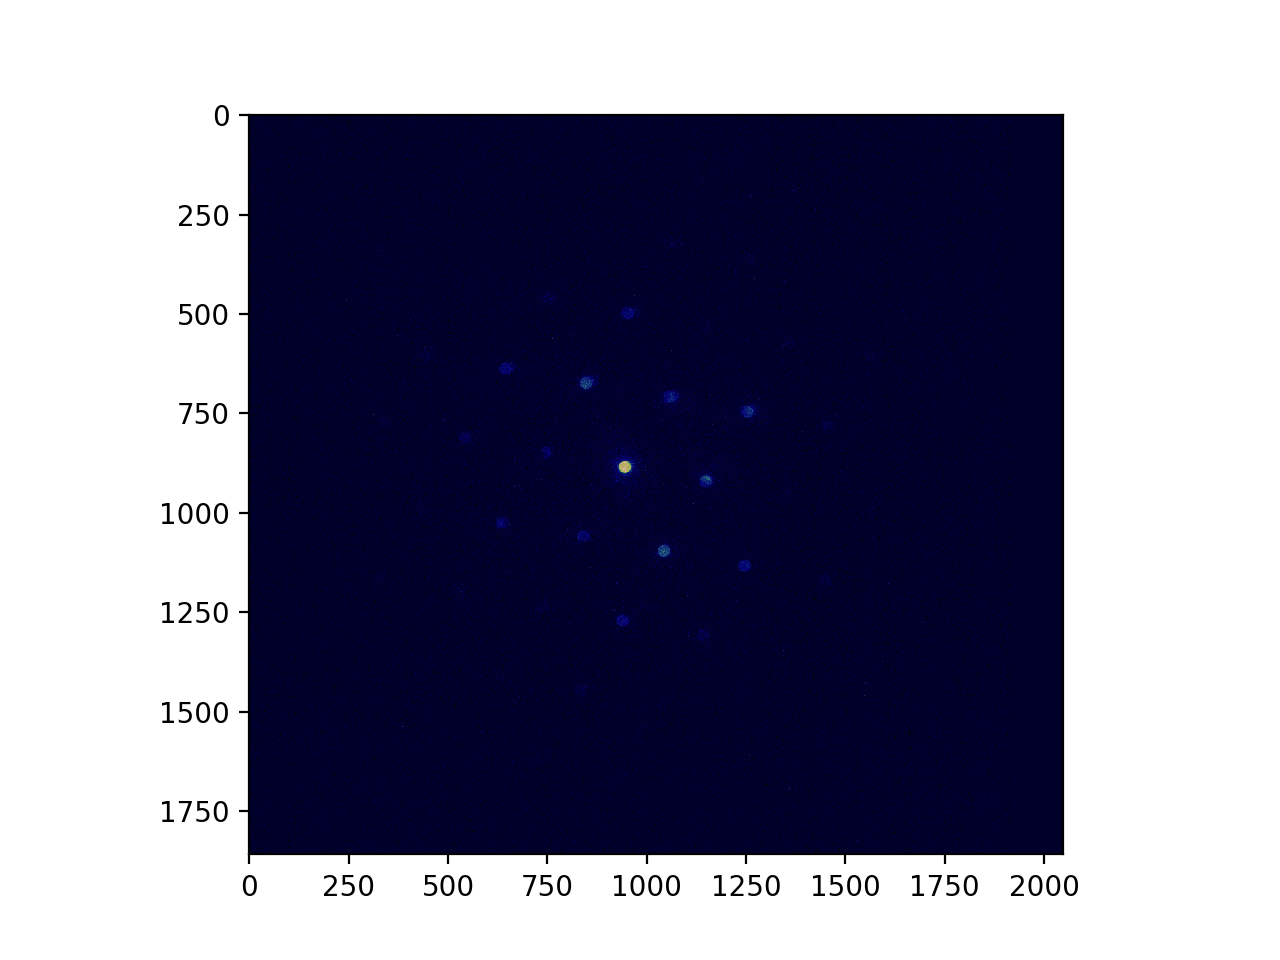

In [23]:
fig, axes = plt.subplots()

axes.imshow(frame_res, cmap="gist_earth")

In [15]:
frame_res.min(), frame_res.max()

(0, 0)